In [1]:
# %matplotlib_svg
import pylab as pl
import numpy as np
import pandas as pd
from glob import glob
pl.rcParams['axes.grid'] = True
pd.set_option("display.show_dimensions", False)
pd.set_option("display.float_format", "{:5.3g}".format)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.rcParams["font.family"] = "simsun" # 可以直接修改設定字典，設定預設字型，這樣就不需要在每次繪製文字時設定字型了
plt.rcParams['axes.unicode_minus']=False    # 當座標軸上的 負號 無法正常顯示時，需加這行 code
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
# plt.xlabel(u"時間", fontproperties=font)

In [3]:
from IPython.core.magic import register_line_magic

@register_line_magic
def C(line):
    from IPython.core.getipython import get_ipython
    from fnmatch import fnmatch

    line = line.strip()
    if ' ' in line:
        idx_space = line.index(' ')
        space_num = line[:idx_space]
        if space_num.isdecimal():
            space_num = int(space_num)
            line = line[idx_space:]
        else:
            space_num = 5
    else:
        space_num = 5

    output_dict = {}
    cmds = line.split(';')
    for cmd in cmds:
        cmd = cmd.strip()
        if cmd != "":
            output_dict[cmd] = repr(eval(cmd)).split("\n")

    str_maxlen_in_cols = [max(len(cmd), len(max(data, key=len))) for cmd, data in output_dict.items()]
    data_row_max = max([len(v) for v in output_dict.values()])

    out_lines = [""]*(data_row_max+2)

    space=''
    for i, (cmd, data) in enumerate(output_dict.items()):
        w = str_maxlen_in_cols[i]

        out_lines[0]+=space+f'{cmd:^{w}}'
        out_lines[1]+=space+"-"*w
        for j, d in enumerate(data, 2):
            out_lines[j]+=space+f'{d:{w}}'

        if len(data) < data_row_max:
            for j in range(len(data)+2, data_row_max+2):
                out_lines[j]+=space+' '*w
        
        space = ' '*space_num

    for line in out_lines:
        print(line)

## 資料處理和可視化案例

本節使用 Pandas 提供的繪圖方法 `plot()` 將計算結果顯示為圖表，其內部使用 `matplotlib` 會圖。

### 分析Pandas專案的傳送歷史

Pandas 的原始程式碼託管於 Github ，由世界各地的同好共同開發。下面使用 Pandas 分析它的傳送記錄檔案 `data/pandas.log` 。

如果電腦中安裝了 git 版本控制軟體，可以透過以下指令建立該檔案：

```
git clone https://github.com/pydata/pandas.git
cd pandas
git log > ../pandas.log
```

該檔案中的一筆傳送記錄由多行文字組成，例如：

```
commit 758ca05e.....
Author: Garrett-R <xxx@xxx.com>
Date: Sat Jun 2715:11:122015 -0700

    DOC: Add warning for newbs not to edit auto-generated file, #10456
```

由於該檔案不是由特定分隔符號分隔的文字檔，無法使用 `read_csv()` 讀取，因此我們自己撰寫資料讀取函數 `read_git_log()` 。它是一個產生器函數，每次反覆運算傳回一個包含作者名、日期和傳送說明的元組。

In [4]:
def read_git_log(log_fn):
    import io
    with io.open(log_fn, "r", encoding="utf8") as f:
        
        author = datetime = None
        message = []
        message_start = False
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            if line.startswith("commit"):
                if author is not None:
                    yield author, datetime, u"\n".join(message)
                    del message[:]
                message_start = False
            elif line.startswith("Author:"):
                author = line[line.index(":")+1 : line.index("<")].strip()
            elif line.startswith("Date:"):
                datetime = line[line.index(":")+1 :].strip()
                message_start = True
            elif message_start:
                message.append(line)

下面將產生器的資料轉為 `DataFrame` 物件，其中包含了 12109 筆傳送記錄：

In [5]:
df_commit = pd.DataFrame(read_git_log("data/pandas.log"), 
                         columns=["Author", "DateString", "Message"])
print( df_commit.shape )

(12109, 3)


為了分析時間資料，需要將傳送時間的字串轉為時間列，使用 `to_datetime()` 可以快速完成這個工作，它會自動嘗試各種常用的日期格式。由下面的輸出可知，它進行了時區轉換，將所有的時間都轉換成了世界標準時間：

In [6]:
df_commit["Date"] = pd.to_datetime(df_commit.DateString)
print( df_commit[["DateString", "Date"]].head() )

                       DateString                       Date
0   Tue Jul 7 23:43:31 2015 -0500  2015-07-07 23:43:31-05:00
1   Tue Jul 7 12:18:50 2015 -0700  2015-07-07 12:18:50-07:00
2   Tue Jul 7 13:37:38 2015 -0500  2015-07-07 13:37:38-05:00
3  Sat Jun 27 15:11:12 2015 -0700  2015-06-27 15:11:12-07:00
4   Tue Jul 7 10:53:55 2015 -0500  2015-07-07 10:53:55-05:00


為了統計每個時區的傳送次數，下面將表示時區的部分分析出來，儲存到 Timezone 列中：

In [7]:
df_commit["Timezone"] = df_commit.DateString.str[-5:]

在傳送說明的每行開頭可能會有全部大寫字母的單字，該單字通常用於描述傳送的分類。在大致瀏覽傳送記錄之後，決定使用正規表示法 `"^([A-Z/]{2,12})"` 分析這種分類資訊。其中 
- `^` 與 `re.MULTILINE` 配合使用，可以比對每行的開頭；
- `()` 括起來的部分就是要分析的內容；
- `[A-Z/]` 比對大寫字母或斜線字元；
- `{2,12}` 表示前面的比對重複 2 到 12 次。

In [8]:
import re
df_commit["Type"] = df_commit.Message.str.extract(r"^([A-Z/]{2,12})", flags=re.MULTILINE)

下面使用 `value_counts()` 統計時區和分類。可以看到美國所在時區的傳送數最多，修復 BUG 的傳送數最多。

In [9]:
tz_counts = pd.value_counts(df_commit.Timezone)
type_counts = pd.value_counts(df_commit.Type)

%C tz_counts.head(); type_counts.head()

      tz_counts.head()              type_counts.head()   
----------------------------     ------------------------
-0400    5057                    BUG    3005             
-0500    2793                    ENH    1720             
-0700    1141                    DOC    1666             
+0200    1052                    TST    1117             
-0800     519                    CLN     424             
Name: Timezone, dtype: int64     Name: Type, dtype: int64


為了方便後續處理，下面將 Date 列設定為行索引，並且按照時間順序排序。注意我們設定 `drop` 參數為 `False`，保留 Date 列。

In [10]:
df_commit.set_index("Date", drop=False, inplace=True)
df_commit.sort_index(inplace=True)

下面統計兩次連續傳送之間的時間間隔，結果如圖 5-8 所示。
- ❶ 對 Date 列呼叫 `diff()` 方法計算前後兩個時間點的差，由於最開始的資料無法計算，因此獲得的值為 `NaN` ，這裡呼叫 `dropna()` 來刪除 `NaN`。
- ❷ 為了方便繪製直方統計圖，這裡將時間差轉為小時數。
- ❸ 呼叫 `plot()` 方法繪圖，透過 `kind` 參數指定圖表的型態為 `"hist"` ，`figsize` 參數指定圖表的大小，其餘的參數都傳遞給實際的繪圖函數 `hist()`，`plot()` 方法傳回表示子圖的物件。

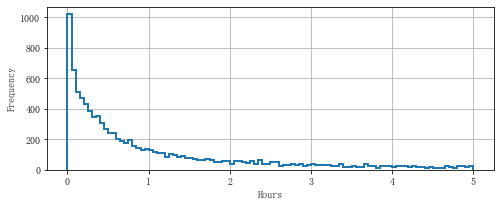

In [11]:
#%fig=兩次傳送的時間間隔統計
time_delta = df_commit.Date.diff(1).dropna() #❶
hours_delta = time_delta.dt.days * 24 + time_delta.dt.seconds / 3600.0 #❷
ax = hours_delta.plot(kind="hist", figsize=(8, 3),   #❸
                      bins=100, histtype="step", range=(0, 5), linewidth=2)
ax.set_xlabel("Hours");

下面的程式繪製每個星期的傳送數，結果如圖 5-9 所示。先呼叫時間序列的 `resample()` 方法對其進行分組計算，其第一個參數為表示分組時間週期的字串，`"W"` 表示按星期分組。`how` 參數指定對每個分組執行的運算。`"count"` 表示傳回每個分組中值不為 `NaN` 的元素個數。因此可以使用不包含 `NaN` 的任何列獲得相同的結果。

(2022-01-20) 
- `resample()` 的 `how` 參數己經不適用了，可以將 `resample(how='count')` 改為 `resample().count()`
- 因為 `index` 的資料是 `Index` 物件，無法使用 `resample()`，所以需將其轉為 `DatetimeIndex` 物件

In [12]:
# 將 Index 轉成 DatetimeIndex
df_commit = df_commit.set_index( pd.DatetimeIndex(pd.to_datetime(df_commit.index, utc=True)) )

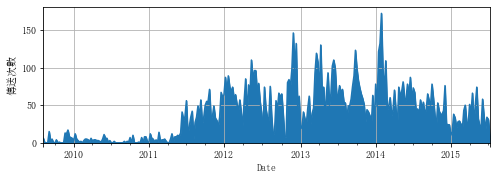

In [13]:
#%fig=每個星期的傳送次數
# ax = df_commit.Author.resample("W", how="count").plot(kind="area", figsize=(8, 2.5))
ax = df_commit.Author.resample("W").count().plot(kind="area", figsize=(8, 2.5))
ax.grid(True)
ax.set_ylabel(u"傳送次數");

`how` 參數還支援回呼函數，例如下面的程式繪製每個月的傳送人數，結果如圖 5-10 所示。這裡使用 `len(s.unique())` 獲得每個分組去重之後的長度：

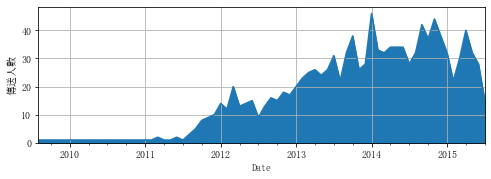

In [14]:
#%fig=每個月的傳送人數
# ax = df_commit.Author.resample("M", how=lambda s:len(s.unique())).plot(
#     kind="area", figsize=(8, 2.5))
ax = df_commit.Author.resample("M").apply(lambda s:len(s.unique())).plot(
    kind="area", figsize=(8, 2.5))
ax.set_ylabel(u"傳送人數");

> **QUESTION**

> 請讀者思考如何使用`groupby()`實現與上述`resample()`相同的運算。

下面使用 `value_counts()` 方法統計每位作者的傳送數。 Pandas 的創始人 WesMcKinney 目前還是排在第一位：

In [15]:
s_authors = df_commit.Author.value_counts()
print( s_authors.head() )

Wes McKinney     3115
jreback          3009
y-p               943
Chang She         629
Phillip Cloud     596
Name: Author, dtype: int64


下面使用 `crosstab()` 統計每個月每位作者的傳送數，所得到的結果 `df_counts` 的行索引為月份，列索引為作者。這裡透過 `DatetimeIndex` 的 `to_period()` 將時間點轉為以月為單位的時間段。結果中包含 72 個月、485位作者的傳送數：

In [16]:
df_counts = pd.crosstab(df_commit.index.to_period("M"), df_commit.Author)
df_counts.index.name = "Month"
print( df_counts.shape )

(72, 485)


D:\Program_File\VSCode_Portable\workon_env\pyElan\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


下面取得 s_authors 中排前 5 名的作者對應的列，並呼叫 `plot()` 繪圖，結果如圖 5-11 所示。預設情況下 `plot()` 將多列資料繪製在一個子圖中。這裡將 `subplots` 參數設定為 True，讓每列資料繪製在不同的子圖中。透過將 `sharex` 和 `sharey` 參數設定為 True，讓所有子圖的 X-Y 軸的資料範圍保持一致，以便比較資料。由圖可知創始人己於 2013 年下半年離開該專案，目前由 jreback 接手。

(2022-01-20)
参数是`axes.prop_cycle` ，而不是`axes.color_cycle`。 然而还需要注意的是， `axes.prop_cycle` 接受一个 `matplotlib.cycler` 实例，而不是一个颜色列表。 所以你的代码应该是
```
rcParams['axes.prop_cycle'] = matplotlib.cycler(color=dark2_colors)
```

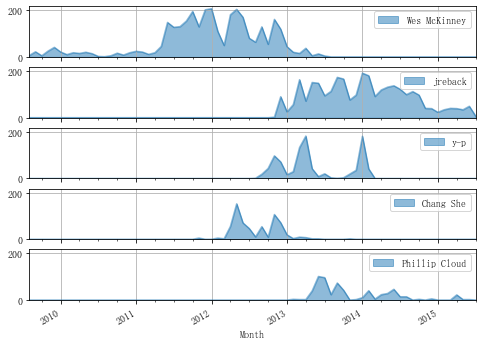

In [17]:
#%fig=前五名作者的每個月傳送次數
df_counts[s_authors.head(5).index].plot(kind="area", 
                                      subplots=True, 
                                      figsize=(8, 6), 
                                      #   color=pl.rcParams['axes.color_cycle'][0],
                                      color=list(pl.rcParams['axes.prop_cycle'])[0]['color'],
                                      alpha=0.5,
                                      sharex=True,
                                      sharey=True);

下面我們繪製與 GitHub 類似的活動記錄圖，效果如圖5-12所示。圖中的每個方塊表示一天的傳送數，每一列表示一個星期。
- ❶ 首先將索引轉為以天為週期的時間段索引，然後統計次數，就獲得了每天的傳送數，其索引為以天為週期的時間段。
- ❷ 將該索引轉換多級索引，第 0 級是以星期為週期的索引，第 1 級是表示星期幾的整數，0 表示星期一。
- ❸ 使用 `unstack()` 將第 0 級索引數轉為列索引，獲得一個 `DataFrame` 物件，取得其最後 60 週的資料之後，將其中的 `NaN` 填充為 0。這樣就獲得了用於做圖的 active_data 資料。

注意 daily_commit 的索引不是按照時間先後順序排列的，但 `unstack()` 傳回的結果中行索引和列索引都是按從小到大的順序排列的：

In [18]:
daily_commit = df_commit.index.to_period("D").value_counts() #❶
daily_commit.index = pd.MultiIndex.from_arrays([daily_commit.index.asfreq("W"),  #❷
                                                daily_commit.index.weekday])
daily_commit = daily_commit.sort_index()
active_data = daily_commit.unstack(0).iloc[:, -60:].fillna(0) #❸

D:\Program_File\VSCode_Portable\workon_env\pyElan\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


下面是繪圖部分，❹ 呼叫 `pcolormesh()` 繪製填充方格，然後呼叫 `set_xticks()` 等函數修改 X 和 Y 軸上刻度的位置和文字：

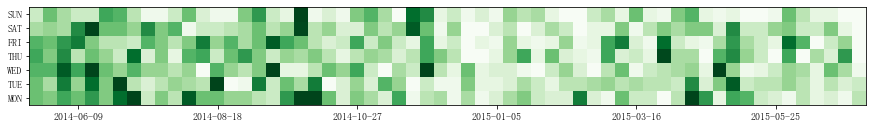

In [19]:
#%fig=Pandas專案的活動記錄圖
fig, ax = pl.subplots(figsize=(15, 4))
ax.set_aspect("equal")
ax.pcolormesh(active_data.values, cmap="Greens", 
              vmin=0, vmax=active_data.values.max() * 0.75) #❹

tick_locs = np.arange(3, 60, 10)
ax.set_xticks(tick_locs + 0.5)
ax.set_xticklabels(active_data.columns[tick_locs].to_timestamp(how="start").format())
ax.set_yticks(np.arange(7) + 0.5)

from pandas.tseries.frequencies import DAYS
ax.set_yticklabels(DAYS);

也可以使用 `plot_dataframe_as_colormesh()` 來繪製，效果見圖 5-12：

In [25]:
import os
print( os.path.abspath(os.path.join(os.getcwd(), "../../codes/")) )


d:\09_Work\Jun_Workspace\Python_Scientific_Computing_Best_Practices\繁中程式碼\codes


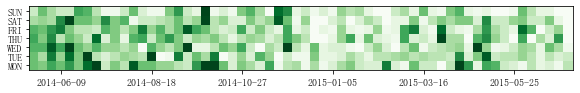

In [30]:
#%nofig
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../codes/")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../codes/scpy2/")))
from scpy2.pandas import plot_dataframe_as_colormesh

plot_dataframe_as_colormesh(active_data, xtick_start=3, xtick_step=10, 
               xtick_format=lambda period:str(period.start_time.date()),
               ytick_format=dict(zip(range(7), DAYS)).get,
               cmap="Greens", vmin=0, vmax=active_data.values.max() * 0.75);

### 分析空氣質量資料

In [31]:
# store = pd.HDFStore("data/aqi/aqi.hdf5")
# df_aqi = store.select("aqi")
with pd.HDFStore("data/aqi/aqi.hdf5") as store:
    df_aqi = store.select("aqi")
df_aqi.head()

,Time,City,Position,AQI,Level,PM2_5,PM10,CO,NO2,O3,SO2
1,2014-04-11 15:00:00,上海,普陀,76,良,49,101,0,0,0,0
2,2014-04-11 15:00:00,上海,十五廠,72,良,52,94,0.479,53,124,9
3,2014-04-11 15:00:00,上海,虹口,80,良,59,98,0.612,52,115,11
4,2014-04-11 15:00:00,上海,徐匯上師大,74,良,54,87,0.706,43,113,14
5,2014-04-11 15:00:00,上海,楊浦四漂,84,良,62,99,0.456,43,82,9


In [32]:
print( df_aqi.City.value_counts() )

天津     134471
北京     109999
上海      92745
天津市        13
北京市        12
上海市        10
Name: City, dtype: int64


In [33]:
df_aqi["City"] = df_aqi.City.str.replace("市", "").astype("category")
print( df_aqi.City.value_counts() )

天津    134484
北京    110011
上海     92755
Name: City, dtype: int64


In [34]:
corr = df_aqi.corr()
print( corr )

         AQI  PM2_5   PM10     CO    NO2     O3    SO2
AQI        1  0.944  0.694  0.611  0.534 -0.136   0.42
PM2_5  0.944      1  0.569  0.633  0.556 -0.169  0.426
PM10   0.694  0.569      1   0.46  0.472 -0.136  0.414
CO     0.611  0.633   0.46      1  0.565 -0.233  0.538
NO2    0.534  0.556  0.472  0.565      1 -0.439  0.448
O3    -0.136 -0.169 -0.136 -0.233 -0.439      1 -0.198
SO2     0.42  0.426  0.414  0.538  0.448 -0.198      1


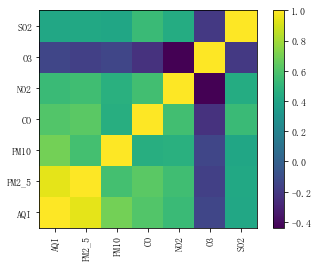

In [37]:
#%fig=空氣質量參數之間的關聯性
plt.rcParams['axes.unicode_minus']=False    # 當座標軸上的 負號無法正常顯示時，需加這行 code
fig, ax = pl.subplots()
plot_dataframe_as_colormesh(corr, ax=ax, colorbar=True, xtick_rot=90);

<AxesSubplot:ylabel='Frequency'>

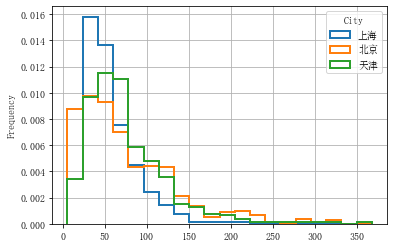

In [39]:
#%fig[1x2]=每個城市的日平均PM2.5的分佈圖
daily_city_groupby = df_aqi.groupby([df_aqi.Time.dt.date, "City"]) #❶
mean_pm2_5 = daily_city_groupby.PM2_5.mean().unstack()  #❷
# normed=1的属性已经取消，可以使用density=True。
# mean_pm2_5.plot(kind="hist", histtype="step", bins=20, normed=True, lw=2) #❸;
mean_pm2_5.plot(kind="hist", histtype="step", bins=20, density=True, lw=2) #❸;

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


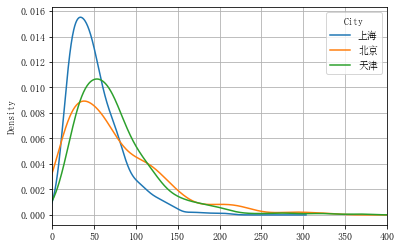

In [40]:
ax = mean_pm2_5.plot(kind="kde")
ax.set_xlim(0, 400);

In [41]:
mean_pm2_5.corr()
#%hide
corr = mean_pm2_5.corr()
corr.index.name = None
corr.columns.name = None
corr

,上海,北京,天津
上海,1,-0.146,0.0718
北京,-0.146,1,0.691
天津,0.0718,0.691,1


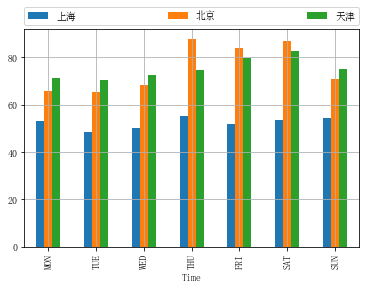

In [43]:
#%fig=一星期中PM2.5的平均值
week_mean = df_aqi.groupby([df_aqi.Time.dt.dayofweek, "City"]).PM2_5.mean()
ax = week_mean.unstack().plot(kind="bar")
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
from pandas.tseries.frequencies import DAYS
ax.set_xticklabels(DAYS);

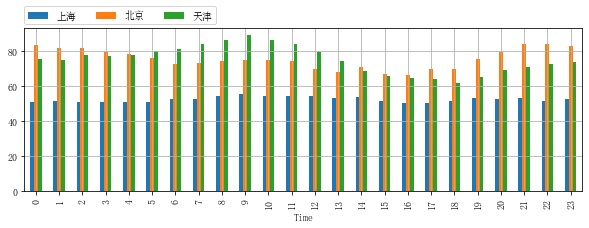

In [45]:
#%fig=一天中不同時段的PM2.5的平均值
hour_mean = df_aqi.groupby([df_aqi.Time.dt.hour, "City"]).PM2_5.mean()
ax = hour_mean.unstack().plot(kind="bar", figsize=(10, 3))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, borderaxespad=0.);

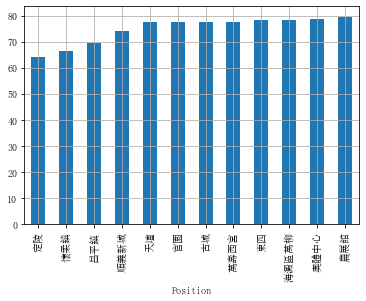

In [47]:
#%fig=北京市各個觀測點的PM2.5的平均值
df_bj = df_aqi.query("City=='北京'")
month_place_mean = df_bj.groupby([df_bj.Time.dt.to_period("M"), "Position"]).PM2_5.mean()
# place_mean = month_place_mean.mean(level=1).order() # 'Series' object has no attribute 'order'
place_mean = month_place_mean.mean(level=1).sort_values()
place_mean.plot(kind="bar");

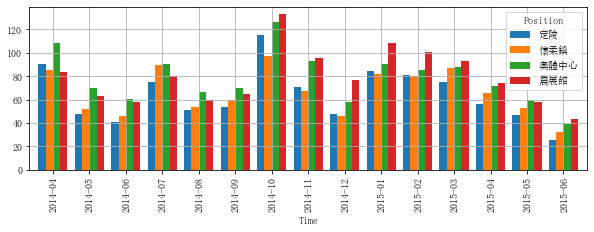

In [48]:
#%fig=北京市各觀測點的月平均PM2.5值
places = place_mean.iloc[[0, 1, -2, -1]].index
month_place_mean.unstack().loc[:, places].plot(kind="bar", figsize=(10, 3), width=0.8);